In [393]:
import numpy as np
import pandas as pd
from math import log
import pandasql as ps
import math
from statistics import mean
import sys
sys.path.append("/Users/fennyzalavadia/Desktop/Verusen_2/tombstone")
from base.services.data_preprocessing.nlp_pre_processing import NLPPreProcessing
nlp = NLPPreProcessing()

In [394]:
import json
def parse_json(s):
    try:
        return json.loads(s)
    except json.JSONDecodeError:
        return None

In [395]:
# Load The dataset containing information
data = pd.read_csv('Dataset/manufacturer_name_materialdetail_export.csv',index_col=None)
df = pd.read_csv('Dataset/Verusen Manufacturer Pair Annotation Task - Task.csv')
#dropping rightmost 2 columns and last row
df.drop(['Unnamed: 7', 'Code','Confidence','Source','Notes'], axis=1,inplace = True)
df.drop(df.tail(1).index,inplace=True)
df.rename(columns={'Company A': 'Company_A','Company B': 'Company_B'},inplace = True)
raters_df = pd.read_csv('Dataset/Verusen Manufacturer Pair Annotation Task - Task (3).csv')#dropping rightmost 2 columns and last row
raters_df.drop(['Unnamed: 7', 'Code','Source','Task Item'], axis=1,inplace = True)
raters_df.rename(columns={'Company A': 'Company_A','Company B': 'Company_B'},inplace = True)
df = df.append(raters_df[(raters_df['Label'] == 1) &(raters_df['Confidence'] == 10)])
df = df.append(raters_df[(raters_df['Label'] == 0) &(raters_df['Notes']>' ')])
df.drop(['Confidence','Notes','Task Item'], axis=1,inplace = True)
# Out of 8000 data, we only have 3000 labeled data.
df = df[df['Label'].notna()]
df

/var/folders/1g/0793y9p52tb41mxnw7d59ndm0000gn/T/ipykernel_22642/3522644630.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(raters_df[(raters_df['Label'] == 1) &(raters_df['Confidence'] == 10)])
/var/folders/1g/0793y9p52tb41mxnw7d59ndm0000gn/T/ipykernel_22642/3522644630.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(raters_df[(raters_df['Label'] == 0) &(raters_df['Notes']>' ')])


Company_A             Company_B  Label
0              ALLEN BRADLEY   ROCKWELL AUTOMATION    3.0
1                 ALLENBRADL         ALLEN BRADLEY    1.0
2              CUTLER HAMMER                 EATON    3.0
3                ALLENBRADLE         ALLEN BRADLEY    1.0
4                  GATESCORP     GATES CORPORATION    1.0
...                      ...                   ...    ...
8831          DORNER COMPANY     DORNER MFG. CORP.    0.0
8833  DRESSER INDUSTRIES INC          DRESSER RAND    0.0
8979                J-B WELD              JET WELD    0.0
8988        JOHNSON & JOHNSO  JOHNSON CONTROLS INC    0.0
9003      KISTLER INSTRUMENT    KISTLER MORSE CORP    0.0

[3001 rows x 3 columns]

In [396]:
df['Label'].value_counts()

1.0    1519
0.0    1132
4.0     210
2.0      85
3.0      55
Name: Label, dtype: int64

In [254]:
# res = ps.sqldf("SELECT df.Company_A, df.Company_B, df.Label, data.num_materials as no_mat_A, data.num_stock_materials as no_stock_A, data.material_groups as mat_grp_A, data.material_descriptions as mat_desc_A, data.average_value as avg_val_A from data, df where data.manufacturer_name == df.Company_A;")
# res = ps.sqldf("SELECT res.Company_A, res.Company_B, res.Label, res.no_mat_A, res.no_stock_A, res.mat_grp_A, res.mat_desc_A,res.avg_val_A, data.num_materials as no_mat_B, data.num_stock_materials as no_stock_B, data.material_groups as mat_grp_B, data.material_descriptions as mat_desc_B, data.average_value as avg_val_B from data, res where data.manufacturer_name == res.Company_B;")
res = pd.read_csv('Dataset/New_data_version2.csv',index_col=None)

In [255]:
#temp_df.to_csv("Dataset/Material_OneHot.csv",index = True)
temp_df_1 = pd.read_csv("Dataset/Material_OneHot.csv")
# Min-Max Normalization
df_new = temp_df_1.drop('manufacturer_name', axis=1)
df_norm = df_new.div(df_new.sum(axis=1), axis=0)
temp_df_1 = pd.concat((temp_df_1.manufacturer_name,df_norm, ), 1)
 
print("Scaled Dataset Using Pandas")
temp_df_1.head()
temp_df_1['combine'] = temp_df_1.loc[:,'0':].values.tolist()
temp_df_1.drop(columns = temp_df_1.columns[1:34],inplace = True)

Scaled Dataset Using Pandas


/var/folders/1g/0793y9p52tb41mxnw7d59ndm0000gn/T/ipykernel_22642/2244482410.py:6: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  temp_df_1 = pd.concat((temp_df_1.manufacturer_name,df_norm, ), 1)


In [256]:
merged_data= temp_df_1.merge(res,how = 'inner',left_on = 'manufacturer_name',right_on = 'Company_A').drop(columns = ['manufacturer_name'])
#merged_data.rename(columns = {'combined':'combined_A'})
res= temp_df_1.merge(merged_data,how = 'inner',left_on = 'manufacturer_name',right_on = 'Company_B').drop(columns = ['manufacturer_name'])
res.rename(columns = {'combined_x':'combined_B','combined_y':'combined_A'},inplace = True)

In [257]:
import pandas as pd
import re
from nltk.corpus import stopwords
from gensim.models import Word2Vec
import multiprocessing

# def clean_data(text):
#     text = re.sub(r'[^ \nA-Za-z0-9À-ÖØ-öø-ÿ/]+', '', text)
#     text = re.sub(r'[\\/×\^\]\[÷]', '', text)
#     return text

def clean_data(text):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',text)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = ''.join((x for x in cleaned if not x.isdigit()))
    return cleaned


def change_lower(text):
    text = text.lower()
    return text

stopwords_list = stopwords.words("english")
def remover(text):
    text_tokens = text.split(" ")
    final_list = [word for word in text_tokens if not word in stopwords_list]
    text = ' '.join(final_list)
    return text

In [258]:
res[['CompanyA']] = res[['Company_A']].astype(str)
res['CompanyA'] = res['CompanyA'].apply(change_lower)
res['CompanyA'] = res['CompanyA'].apply(clean_data)
res['CompanyA'] = res['CompanyA'].apply(remover)

res[['CompanyB']] = res[['Company_B']].astype(str)
res['CompanyB'] = res['CompanyB'].apply(change_lower)
res['CompanyB'] = res['CompanyB'].apply(clean_data)
res['CompanyB'] = res['CompanyB'].apply(remover)

res[['mat_desc_A']] = res[['mat_desc_A']].astype(str)
res['mat_desc_A'] = res['mat_desc_A'].apply(change_lower)
res['mat_desc_A'] = res['mat_desc_A'].apply(clean_data)
res['mat_desc_A'] = res['mat_desc_A'].apply(remover)

res[['mat_desc_B']] = res[['mat_desc_B']].astype(str)
res['mat_desc_B'] = res['mat_desc_B'].apply(change_lower)
res['mat_desc_B'] = res['mat_desc_B'].apply(clean_data)
res['mat_desc_B'] = res['mat_desc_B'].apply(remover)

In [259]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import spatial
from sklearn.metrics.pairwise import cosine_similarity
res['ab'] = res.apply(lambda x : x['CompanyA'] + ' ' + x['CompanyB'], axis=1)

clf_1 = TfidfVectorizer(ngram_range=(1, 1))
clf_1.fit(res['ab'])


tfidf_a = clf_1.transform(res['CompanyA'])
tfidf_b = clf_1.transform(res['CompanyB'])

# res['Company_AB'] = np.diag(cosine_similarity(tfidf_a, tfidf_b))


In [260]:
bad_keywords = set(['start', 'ray', 'case', 'forest', 'viking', 'tc', 'cam', 'fmc', 'fenner', 'hub', 'du', 'reulanc', 'soft', 'textile', 'blake', 'it', 'blount', 'di', 'eq', 'imp', 'irwin', 'wolf', 'sprout', 'el', 'gen','plastics','electronics','pumps','bearings','cylinder','inc', 'corp', 'siemens', 'goulds', 'indust', 'itt', 'crane', 'superior', 'stearns', 'works','automation', 'international', 'inc', 'sales', 'industries', 'misc', 'power', 'machine', 'products', 'industrial', 'co', 'tool', 'products', 'hydraulics', 'corporation', 'gear', 'sprocket', 'systems', 'company', 'mfg', 'usa', 'supply', 'electronic', '&', 'hoists', 'limited', 'llc', 'div', 'electric', 'pump', 'controls', 'tech', ';', 'non-strategic', 'manufacturing', 'corp', 'safety', 'gasket', 'hydro', 'product', 'equipment', 'fluid', 'power', 'brush', 'hardware', 'incorporated', 'instruments', 'fasteners', 'machinery', 'solutions', 'stainless', 'instrument', 'int', 'ltd', 'filter', 'wire', 'prod', 'technologies', 'rubber', 'quality', 'specialties', 'foam', 'bearing', 'carts'])
def clean_common_keywords(text):
    cleaned = ' '.join(x for x in text.split(' ') if x not in bad_keywords)
    return cleaned



In [261]:
res['CompanyA'] = res['CompanyA'].apply(clean_common_keywords)
res['CompanyB'] = res['CompanyB'].apply(clean_common_keywords)

In [262]:
avg_len = ((res["CompanyA"].str.len()).median()+(res["CompanyB"].str.len()).median())/2
np.where(res.applymap(lambda x: x == ''))
res = res.replace('', np.nan)
res.dropna(inplace = True)
res.reset_index(drop=True,inplace = True)

In [263]:
from similarity.jarowinkler import JaroWinkler
from pyjarowinkler import distance
res["jarowinkler_sim_penalty"] = [distance.get_jaro_distance(i,j)*(math.exp(-max(0,avg_len/mean([len(i),len(j)])  - 1))) for i,j in zip(res["CompanyA"],res["CompanyB"])]
res["jarowinkler_sim"] = [distance.get_jaro_distance(i,j) for i,j in zip(res["CompanyA"],res["CompanyB"])]

In [264]:
res['ab'] = res.apply(lambda x : x['CompanyA'] + ' ' + x['CompanyB'], axis=1)

clf_1 = TfidfVectorizer(ngram_range=(1, 1))
clf_1.fit(res['ab'])


tfidf_a = clf_1.transform(res['CompanyA'])
tfidf_b = clf_1.transform(res['CompanyB'])

# row_similarities = [1 - spatial.distance.cosine(tfidf_a[x],tfidf_b[x]) for x in range(len(tfidf_a)) ]
# res['Company_AB'] = row_similarities

res['Company_AB'] = np.diag(cosine_similarity(tfidf_a, tfidf_b))


res['desc_ab'] = res.apply(lambda x : x['mat_desc_A'] + ' ' + x['mat_desc_B'], axis=1)

clf_3 = TfidfVectorizer(ngram_range=(1, 1))
clf_3.fit(res['desc_ab'])


tfidf_desc_a = clf_3.transform(res['mat_desc_A'])
tfidf_desc_b = clf_3.transform(res['mat_desc_B'])

# row_similarities = [1 - spatial.distance.cosine(tfidf_grp_a[x],tfidf_grp_b[x]) for x in range(len(tfidf_grp_a)) ]
res['Desc_AB'] = np.diag(cosine_similarity(tfidf_desc_a,tfidf_desc_b))

res['Cat_AB'] = [cosine_similarity([res['combine_x'][i]],[res['combine_y'][i]])[0][0] for i in range(res.shape[0])]

In [265]:
from sentence_transformers import SentenceTransformer, util
import numpy as np
model = SentenceTransformer('stsb-roberta-large')

In [266]:
# encode sentences to get their embeddings
embedding1 = model.encode(res['Company_A'], convert_to_tensor=True)
embedding2 = model.encode(res['Company_B'], convert_to_tensor=True)
# compute similarity scores of two embeddings
cosine_scores = util.pytorch_cos_sim(embedding1, embedding2)
res['Sim_AB'] = np.diag(cosine_scores)

In [267]:
df = res[['Company_A', 'Company_B', 'CompanyA', 'CompanyB','Company_AB','Desc_AB','jarowinkler_sim','jarowinkler_sim_penalty','Cat_AB','Sim_AB','Label']]
# Convert the labels of data as Label 1 and other data Label 0
df['Label'].loc[df['Label'] != 1] = 0
df['Label'].value_counts()

/var/folders/1g/0793y9p52tb41mxnw7d59ndm0000gn/T/ipykernel_22642/1915060538.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Label'].loc[df['Label'] != 1] = 0


0.0    692
1.0    629
Name: Label, dtype: int64

In [268]:
df

Company_A                Company_B  \
0                ACCUFORM SIGNS           ACCUFORM SIGNS   
1                ACCUFORM SIGNS           ACCUFORM SIGNS   
2                     ACS GROUP           ACS INDUSTRIES   
3        ACTION INSTRUMENTS INC               ACTION PAK   
4                         ADAMS  ADAMS MAGNETIC PRODUCTS   
...                         ...                      ...   
1316  JOHNSON YOKOGAWA CORPORAT                 YOKOGAWA   
1317                      YOUNG      YOUNG POWERTECH INC   
1318                        ZEP      ZEP SALES & SERVICE   
1319                ZIEHL ABEGG              ZIEHL-ABEGG   
1320           ZINGA INDUSTRIES   ZINGA INDUSTRIES, INC.   

                       CompanyA         CompanyB  Company_AB   Desc_AB  \
0                accuform signs   accuform signs    1.000000  1.000000   
1                accuform signs   accuform signs    1.000000  1.000000   
2                     acs group              acs    0.803715  0.221997   
3                        action       action pak    0.707107  0.394531   
4                         adams   adams magnetic    0.692312  0.002280   
...                         ...              ...         ...       ...   
1316  johnson yokogawa corporat         yokogawa    0.615590  0.421855   
1317                      young  young powertech    0.707107  0.244231   
1318                        zep      zep service    0.726488  0.669428   
1319                ziehl abegg      ziehl-abegg    1.000000  0.263963   
1320                      zinga          zinga      1.000000  0.180076   

      jarowinkler_sim  jarowinkler_sim_penalty    Cat_AB    Sim_AB  Label  
0                1.00                 1.000000  1.000000  1.000000    1.0  
1                1.00                 1.000000  1.000000  1.000000    1.0  
2                0.84                 0.601886  0.439980  0.737680    0.0  
3                0.92                 0.920000  0.995249  0.462645    0.0  
4                0.87                 0.870000  0.127128  0.608365    1.0  
...               ...                      ...       ...       ...    ...  
1316             0.44                 0.440000  0.973056  0.568813    0.0  
1317             0.87                 0.870000  0.570687  0.435525    1.0  
1318             0.83                 0.719509  0.959810  0.680715    1.0  
1319             0.96                 0.960000  0.935414  0.763496    1.0  
1320             0.94                 0.673539  0.027122  0.934879    1.0  

[1321 rows x 11 columns]

In [269]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.metrics import cohen_kappa_score

In [270]:
test_df = df.sample(frac = 0.2,random_state = 135)
train_df = df.sample(frac = 0.8,random_state = 135)

In [271]:
# Assign values to the X and y variables:

X_train = train_df.iloc[:, :10].values
y_train = train_df.iloc[:, 10].values 
X_test = test_df.iloc[:, :10].values
y_test = test_df.iloc[:, 10].values 

X_train_new = [x[4:] for x in X_train]
X_test_new = [x[4:] for x in X_test]

from sklearn.impute import SimpleImputer

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp = imp.fit(X_train_new)
X_train_new = imp.transform(X_train_new)
X_test_new = imp.transform(X_test_new) 

# Standardize features by removing mean and scaling to unit variance:
scaler = StandardScaler()
scaler.fit(X_train_new)
X_train_new = scaler.transform(X_train_new)
X_test_new = scaler.transform(X_test_new) 

In [398]:
y_test.shape

(264,)

In [272]:
# Use the KNN classifier to fit data:
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train_new, y_train) 
# Predict y data with classifier: 
y_predict_KNN = classifier.predict(X_test_new)
# Print results: 
print(confusion_matrix(y_test, y_predict_KNN))
print(classification_report(y_test, y_predict_KNN)) 
print(accuracy_score(y_test, y_predict_KNN))
cohen_kappa_score(y_test, y_predict_KNN)

[[120  18]
 [ 19 107]]
              precision    recall  f1-score   support

         0.0       0.86      0.87      0.87       138
         1.0       0.86      0.85      0.85       126

    accuracy                           0.86       264
   macro avg       0.86      0.86      0.86       264
weighted avg       0.86      0.86      0.86       264

0.8598484848484849


0.7190196755264067

In [273]:
threshold = 0.8
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train_new,y_train)
predicted_proba = clf.predict_proba(X_test_new)
predictionLR = (predicted_proba[:,1] >= threshold).astype('int')

print(accuracy_score(y_test, predictionLR))


0.7386363636363636


In [274]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
sgd = make_pipeline(StandardScaler(),
SGDClassifier(max_iter=1000, tol=1e-3))
sgd.fit(X_train_new,y_train)

predicted_SGD = sgd.predict(X_test_new)
log_probab = sgd.decision_function(X_test_new)

print(accuracy_score(y_test, predicted_SGD))

0.7916666666666666


In [275]:
from sklearn.tree import DecisionTreeClassifier
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3)

# Train Decision Tree Classifer
clf = clf.fit(X_train_new,y_train)

#Predict the response for test dataset
y_pred_DT = clf.predict(X_test_new)
print(accuracy_score(y_test, y_pred_DT))

0.821969696969697


In [276]:
# Check Missclassified Data - DT
df_0 = pd.DataFrame()
df_0['Actual'] = y_test
df_0['Label_DT'] = y_pred_DT
df_0['Label_KNN'] = y_predict_KNN
df_0['Label_SGD'] = predicted_SGD
df_1 = pd.DataFrame(X_test,columns = ['Company_A','Company_B','CompanyA','CompanyB','Company_AB','Desc_AB','jarowinkler_sim','jarowinkler_sim_penalty','Cat_AB','Sim_AB'])
df_1 = df_1.join(df_0)

In [278]:
df_1[df_1['Actual']!=df_1['Label_DT']][df_1['Label_DT'] == 0]

/var/folders/1g/0793y9p52tb41mxnw7d59ndm0000gn/T/ipykernel_22642/2121044054.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_1[df_1['Actual']!=df_1['Label_DT']][df_1['Label_DT'] == 0]


Company_A                  Company_B  \
0          PEPPERL & FUCHS INC                        P&F   
30                  MARQUIPWAR               WARD MACHINE   
41                     HOFFMAN                     MCLEAN   
46                    APPLETON                       RACO   
69   LIQUID SOLIDS CONTROL INC                        LSC   
81                      SIEMEN  SIEMENS ENERGY AND AUTOMA   
87                 EXXON MOBIL                      MOBIL   
105             EATON AIR FLEX                     FAWICK   
112                        P&H  P&H CRANE HOIST & ENG. CO   
115         SCHNEIDER ELECTRIC           SQUARE D COMPANY   
141                EATONVICKER                    VICKERS   
153                     AMETEK                        NCC   
154                       BM&M     BM&M SCREENING SOLUTIO   
156                    CELLECO                       GL&V   
160            EWELLIX USA LLC                SKF USA INC   
163                        RBC  ROLLER BEARINGS OF AMERIC   
177                MTS SYSTEMS                      TEMPO   
193                      STONE  STONE CONTAINER CORPORATI   
213                 BECK HAROL     HAROLD BECK & SONS INC   
262  SIEMENS APPLIED AUTOMATIO  SIEMENS ENERGY AND AUTOMA   

                  CompanyA                   CompanyB Company_AB   Desc_AB  \
0            pepperl fuchs                        p&f        0.0  0.586846   
30              marquipwar                       ward        0.0    0.6238   
41                 hoffman                     mclean        0.0  0.114382   
46                appleton                       raco        0.0  0.420357   
69   liquid solids control                        lsc        0.0  0.104526   
81                  siemen              energy automa        0.0  0.481681   
87             exxon mobil                      mobil   0.707107  0.684823   
105         eaton air flex                     fawick        0.0  0.346007   
112                    p&h             p&h hoist eng         0.0  0.406941   
115              schneider                     square        0.0  0.339847   
141            eatonvicker                    vickers        0.0   0.29204   
153                 ametek                        ncc        0.0  0.055225   
154                   bm&m     bm&m screening solutio    0.57735  0.155566   
156                celleco                       gl&v        0.0  0.356295   
160                ewellix                        skf        0.0  0.091945   
163                    rbc              roller americ        0.0  0.798266   
177                    mts                      tempo        0.0  0.088637   
193                  stone  stone container corporati   0.587756  0.577321   
213             beck harol           harold beck sons   0.372979  0.385873   
262      applied automatio              energy automa        0.0  0.274019   

    jarowinkler_sim jarowinkler_sim_penalty    Cat_AB    Sim_AB  Actual  \
0              0.52                    0.52  0.997991  0.438582     1.0   
30             0.57                 0.49412  0.920331  0.284055     1.0   
41             0.54                0.428718  0.273267  0.108904     1.0   
46             0.46                0.329604  0.814588  0.005604     1.0   
69             0.51                    0.51  0.957572  0.275985     1.0   
81              0.5                     0.5  0.984294  0.482639     1.0   
87             0.43                    0.43  0.997036  0.310394     1.0   
105            0.41                    0.41  0.988668  0.163577     1.0   
112            0.82                    0.82  0.850221  0.226664     1.0   
115            0.57                0.533239  0.985653  0.309765     1.0   
141             0.0                     0.0  0.912229  0.448624     1.0   
153             0.0                     0.0  0.781911   0.18689     1.0   
154            0.84                    0.84  0.561187  0.367174     1.0   
156            0.46                0.291979  0.967

In [281]:
df_1[(df_1['Label_DT'] == 1)& (df_1['Label_KNN'] == 1)&(df_1['Label_SGD'] == 1) & (df_1['Actual'] == 0)]

Company_A                 Company_B  \
11           MAC EQUIPMENT INC            MAC VALVES INC   
14             MISC US BEARING                        US   
21    METSO AUTOMATION USA INC               METSO PAPER   
53    TOSHIBA AMERICA CONSUMER          TOSHIBA ELECTRIC   
54         EAGLE MANUFACTURING               EAGLE MATER   
83    METSO AUTOMATION USA INC             METSO/KAJAANI   
104               PARKER FLUID           PARKER HANNIFIN   
164        TSUBAKI CONVEYOR CO      TSUBAKIMOTO CHAIN CO   
181  PNEUMATIC & HYDRAULICS CO         PNEUMATIC COMPANY   
182         MILLER FLUID POWER              MILLER SALES   
220     BROWN PAPER CONVERTING  PAPER CONVERTING MACHINE   
221                        SUN       SUN HYDRAULICS CORP   
228  TOSHIBA INTERNATIONAL COR              TOSHIBAMERIC   
240        LITTLE GIANT LADDER         LITTLE GIANT PUMP   
243                    MARQUIP                MARQUIPWAR   

                     CompanyA           CompanyB Company_AB   Desc_AB  \
11                        mac         mac valves   0.725163  0.574921   
14                         us                 us        1.0  0.071179   
21                      metso        metso paper   0.726563  0.467964   
53   toshiba america consumer            toshiba   0.518523  0.924778   
54                      eagle        eagle mater    0.68718   0.00195   
83                      metso      metso kajaani   0.627187  0.209855   
104                    parker    parker hannifin   0.676678  0.708501   
164          tsubaki conveyor  tsubakimoto chain        0.0  0.903986   
181                 pneumatic          pneumatic        1.0  0.102164   
182                    miller             miller        1.0  0.017002   
220    brown paper converting   paper converting   0.765993  0.228947   
221                       sun                sun        1.0   0.78507   
228               toshiba cor       toshibameric        0.0  0.831341   
240       little giant ladder       little giant   0.791312  0.147093   
243                   marquip         marquipwar        0.0  0.865264   

    jarowinkler_sim jarowinkler_sim_penalty    Cat_AB    Sim_AB  Actual  \
11             0.84                0.666895  0.212561  0.663203     0.0   
14              1.0                0.049787  0.660974  0.435852     0.0   
21             0.89                    0.89  0.860385  0.629266     0.0   
53             0.86                    0.86  0.999934  0.804397     0.0   
54             0.89                    0.89  0.041612   0.68975     0.0   
83             0.88                    0.88   0.73574  0.539695     0.0   
104            0.88                    0.88  0.973203  0.342575     0.0   
164            0.86                    0.86  0.999271  0.735683     0.0   
181             1.0                     1.0       0.0   0.71605     0.0   
182             1.0                0.716531  0.542273  0.668405     0.0   
220            0.76                    0.76  0.911519  0.427129     0.0   
221             1.0                0.188876  0.770943  0.376616     0.0   
228            0.89                    0.89  0.978391   0.59351     0.0   
240            0.93                    0.93       1.0  0.467101     0.0   
243            0.94                    0.94  0.974368  0.709616     0.0   

     Label_DT  Label_KNN  Label_SGD  
11        1.0        1.0        1.0  
14        1.0        1.0        1.0  
21        1.0        1.0        1.0  
53        1.0        1.0        1.0  
54        1.0        1.0        1.0  
83        1.0        1.0        1.0  
104       1.0        1.0        1.0  
164       1.0        1.0        1.0  
181       1.0        1.0        1.0  
182       1.0        1.0        1.0  
220       1.0        1.0        1.0  
221       1.0        1.0        1.0  
228       1.0        1.0        1.0  
240       1.0        1.0        1.0  
243       1.0        1.0        1.0

In [282]:
df_1[(df_1['Label_DT'] == 0)& (df_1['Label_KNN'] == 0)&(df_1['Label_SGD'] == 0) & (df_1['Actual'] == 1)]

Company_A                  Company_B  \
30                  MARQUIPWAR               WARD MACHINE   
41                     HOFFMAN                     MCLEAN   
46                    APPLETON                       RACO   
69   LIQUID SOLIDS CONTROL INC                        LSC   
105             EATON AIR FLEX                     FAWICK   
115         SCHNEIDER ELECTRIC           SQUARE D COMPANY   
141                EATONVICKER                    VICKERS   
153                     AMETEK                        NCC   
156                    CELLECO                       GL&V   
160            EWELLIX USA LLC                SKF USA INC   
163                        RBC  ROLLER BEARINGS OF AMERIC   
177                MTS SYSTEMS                      TEMPO   
213                 BECK HAROL     HAROLD BECK & SONS INC   

                  CompanyA          CompanyB Company_AB   Desc_AB  \
30              marquipwar              ward        0.0    0.6238   
41                 hoffman            mclean        0.0  0.114382   
46                appleton              raco        0.0  0.420357   
69   liquid solids control               lsc        0.0  0.104526   
105         eaton air flex            fawick        0.0  0.346007   
115              schneider            square        0.0  0.339847   
141            eatonvicker           vickers        0.0   0.29204   
153                 ametek               ncc        0.0  0.055225   
156                celleco              gl&v        0.0  0.356295   
160                ewellix               skf        0.0  0.091945   
163                    rbc     roller americ        0.0  0.798266   
177                    mts             tempo        0.0  0.088637   
213             beck harol  harold beck sons   0.372979  0.385873   

    jarowinkler_sim jarowinkler_sim_penalty    Cat_AB    Sim_AB  Actual  \
30             0.57                 0.49412  0.920331  0.284055     1.0   
41             0.54                0.428718  0.273267  0.108904     1.0   
46             0.46                0.329604  0.814588  0.005604     1.0   
69             0.51                    0.51  0.957572  0.275985     1.0   
105            0.41                    0.41  0.988668  0.163577     1.0   
115            0.57                0.533239  0.985653  0.309765     1.0   
141             0.0                     0.0  0.912229  0.448624     1.0   
153             0.0                     0.0  0.781911   0.18689     1.0   
156            0.46                0.291979  0.967769  0.228404     1.0   
160             0.0                     0.0  0.691684  0.510607     1.0   
163            0.52                    0.52  0.997654  0.363823     1.0   
177            0.51                0.187619   0.91837  0.337311     1.0   
213            0.49                    0.49   0.97504  0.367855     1.0   

     Label_DT  Label_KNN  Label_SGD  
30        0.0        0.0        0.0  
41        0.0        0.0        0.0  
46        0.0        0.0        0.0  
69        0.0        0.0        0.0  
105       0.0        0.0        0.0  
115       0.0        0.0        0.0  
141       0.0        0.0        0.0  
153       0.0        0.0        0.0  
156       0.0        0.0        0.0  
160       0.0        0.0        0.0  
163       0.0        0.0        0.0  
177       0.0        0.0        0.0  
213       0.0        0.0        0.0

In [284]:
df_1.to_csv("Output/Test_result_1.csv")

In [41]:
distance.get_jaro_distance('eatonvicker','vickers')

0.0

In [42]:
distance.get_jaro_distance('siemen','energy automa')

0.5

## Testing on Unseen Data

In [285]:
manufacturers = pd.read_csv("Dataset/verusen_manufacturer_names_materialdetail_export_11032022.csv")
manufacturers = manufacturers[['manufacturer_name','material_descriptions']]
merged_data= temp_df_1.merge(manufacturers,how = 'inner',left_on = 'manufacturer_name',right_on = 'manufacturer_name')
merged_data  = merged_data[:3000]

In [286]:
merged_data.reset_index(inplace = True)
merged_data[['manufacturer_name_clean']] = merged_data[['manufacturer_name']].astype(str)
merged_data['manufacturer_name_clean'] = merged_data['manufacturer_name_clean'].apply(change_lower)
merged_data['manufacturer_name_clean'] = merged_data['manufacturer_name_clean'].apply(clean_data)
merged_data['manufacturer_name_clean'] = merged_data['manufacturer_name_clean'].apply(remover)
merged_data['manufacturer_name_clean'] = merged_data['manufacturer_name_clean'].apply(clean_common_keywords)
merged_data[['material_descriptions']] = merged_data[['material_descriptions']].astype(str)
merged_data['material_descriptions'] = merged_data['material_descriptions'].apply(change_lower)
merged_data['material_descriptions'] = merged_data['material_descriptions'].apply(clean_data)
merged_data['material_descriptions'] = merged_data['material_descriptions'].apply(remover)

In [287]:
np.where(merged_data.applymap(lambda x: x == ''))
merged_data = merged_data.replace('', np.nan)
merged_data.dropna(inplace = True)
merged_data.reset_index(drop=True,inplace = True)

clf_1 = TfidfVectorizer(ngram_range=(1, 1))
clf_1.fit(merged_data['manufacturer_name_clean'])
tfidf_a = clf_1.transform(merged_data['manufacturer_name_clean'])

clf_2 = TfidfVectorizer(ngram_range=(1, 1))
clf_2.fit(merged_data['material_descriptions'])
tfidf_desc = clf_2.transform(merged_data['material_descriptions'])

In [288]:
unseen_data_full = pd.DataFrame()
unseen_data_full[['Company_A', 'Company_B']] = [[i,j] for i in merged_data['manufacturer_name'] for j in merged_data['manufacturer_name'] ]
unseen_data_full[['CompanyA', 'CompanyB']] = [[i,j] for i in merged_data['manufacturer_name_clean'] for j in merged_data['manufacturer_name_clean'] ]
unseen_data_full["jarowinkler_sim"] = [distance.get_jaro_distance(i,j) for i in merged_data['manufacturer_name_clean'] for j in merged_data['manufacturer_name_clean']]
avg_len = ((unseen_data_full["Company_A"].str.len()).median()+(unseen_data_full["Company_B"].str.len()).median())/2
unseen_data_full["jarowinkler_sim_penalty"] = [distance.get_jaro_distance(i,j)*(math.exp(-max(0,avg_len/mean([len(i),len(j)])  - 1))) for i in merged_data['manufacturer_name_clean'] for j in merged_data['manufacturer_name_clean']]

unseen_data_full["Company_AB"] = [j for sub in cosine_similarity(tfidf_a, tfidf_a) for j in sub]
unseen_data_full["Desc_AB"] = [j for sub in cosine_similarity(tfidf_desc, tfidf_desc) for j in sub]


In [289]:
embedding1 = model.encode(merged_data['manufacturer_name'], convert_to_tensor=True)
# # compute similarity scores of two embeddings
cosine_scores = util.pytorch_cos_sim(embedding1, embedding1)
unseen_data_full["Sim_AB"] = [j for sub in cosine_scores for j in sub]

In [290]:
unseen_data_full['Sim_AB'] = [j.item() for j in unseen_data_full['Sim_AB']]

In [291]:
from scipy.sparse import csr_matrix
#unseen_data_full["Cat_AB"] = [cosine_similarity([merged_data['combine'][i]], [merged_data['combine'][j]])[0][0].round(decimals=5) for i in range(1000) for j in range(1000)]
unseen_data_full["Cat_AB"] = [j for sub in cosine_similarity(csr_matrix(np.vstack(merged_data['combine'].values)), csr_matrix(np.vstack(merged_data['combine'].values))) for j in sub]
csr_matrix(np.vstack(merged_data['combine'].values))

<2983x33 sparse matrix of type '<class 'numpy.float64'>'
	with 11455 stored elements in Compressed Sparse Row format>

In [292]:
X_unseen = unseen_data_full[['Company_AB','Desc_AB','jarowinkler_sim', 'jarowinkler_sim_penalty','Cat_AB','Sim_AB']]

In [293]:
# KNN
predictive_labels_KNN = classifier.predict_proba(X_unseen)
threshold = 0.8
predictionKNN = (predictive_labels_KNN[:,1] >= threshold).astype('int')
unseen_data_full['Label_KNN']  = predictionKNN

predicted_SGD = sgd.predict(X_unseen)
unseen_data_full['Label_SGD']  = predicted_SGD

predicted_DT = clf.predict(X_unseen)
unseen_data_full['Label_DT']  = predicted_DT

/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


In [336]:
unseen_data_full[(unseen_data_full['Label_DT'] == 1.0)&
                 (unseen_data_full['Label_KNN'] == 1)&
                 (unseen_data_full['Label_SGD'] == 1.0)&
                 (unseen_data_full['jarowinkler_sim']>0.5) &
                 (unseen_data_full['Company_AB']>0.5) &
                             (unseen_data_full['Company_A']> unseen_data_full['Company_B']) &
                            (unseen_data_full['Cat_AB']>0.5)]

Company_A             Company_B              CompanyA  \
92502     AB INDUSTRIAL EQUIPMENT          AB CHANCE CO                    ab   
98471             ABC COMPOUNDING                   ABC       abc compounding   
107423      ABC PACKAGING MACHINE         ABC PACKAGING         abc packaging   
110406               ABC PLASTICS         ABC PACKAGING                   abc   
161132   ABRASIVE TECHNOLOGY,INC.  ABRASIVE ACCESSORIES  abrasive technology    
...                           ...                   ...                   ...   
8804826               BRIGHT STAR              B&L STAR           bright star   
8817256             BRIGHTON BEST    BEST MANUFACTURING         brighton best   
8871599               BRO-TEX INC         ACE-TEX CORP.               bro-tex   
8883367         BROAN-NUTONE LLC.                 BROAN         broan-nutone    
8892319   BRODERSON MANUFACTURING             BRODERSON             broderson   

                     CompanyB  jarowinkler_sim  jarowinkler_sim_penalty  \
92502               ab chance             0.79                 0.140437   
98471                     abc             0.81                 0.415868   
107423          abc packaging             1.00                 0.857404   
110406          abc packaging             0.82                 0.341827   
161132   abrasive accessories             0.82                 0.820000   
...                       ...              ...                      ...   
8804826              b&l star             0.74                 0.414761   
8817256                  best             0.60                 0.279282   
8871599              ace-tex              0.61                 0.224406   
8883367                 broan             0.88                 0.451807   
8892319             broderson             1.00                 0.513417   

         Company_AB   Desc_AB    Sim_AB    Cat_AB  Label_KNN  Label_SGD  \
92502      0.675685  0.000000  0.429836  1.000000          1        1.0   
98471      0.647298  0.000000  0.661648  0.872448          1        1.0   
107423     1.000000  0.113453  0.821331  0.755210          1        1.0   
110406     0.749662  0.000000  0.679519  0.707107          1        1.0   
161132     0.520995  0.050224  0.726070  0.936490          1        1.0   
...             ...       ...       ...       ...        ...        ...   
8804826    0.665984  0.010453  0.433401  1.000000          1        1.0   
8817256    0.612421  0.002579  0.275718  0.768409          1        1.0   
8871599    0.523012  0.135455  0.453858  0.979958          1        1.0   
8883367    0.689204  0.627928  0.639229  0.744839          1        1.0   
8892319    1.000000  0.166342  0.712139  0.546007          1        1.0   

         Label_DT  
92502         1.0  
98471         1.0  
107423        1.0  
110406        1.0  
161132        1.0  
...           ...  
8804826       1.0  
8817256       1.0  
8871599       1.0  
8883367       1.0  
8892319       1.0  

[1107 rows x 13 columns]

In [338]:
new_data = unseen_data_full[(unseen_data_full['Label_DT'] == 1.0)&
                 (unseen_data_full['Label_KNN'] == 1)&
                 (unseen_data_full['Label_SGD'] == 1.0)&
                 (unseen_data_full['jarowinkler_sim']>0.5) &
                 (unseen_data_full['Company_AB']>0.5) &
                             (unseen_data_full['Company_A']> unseen_data_full['Company_B']) &
                            (unseen_data_full['Cat_AB']>0.5)]
new_data = new_data.append(unseen_data_full[(unseen_data_full['Label_DT'] == 0)&
                                (unseen_data_full['Label_KNN'] == 0)&
                                (unseen_data_full['Label_SGD'] == 0)&
                                (unseen_data_full['Label_DT'] == 0)&
                                            
                                (unseen_data_full['Company_A']> unseen_data_full['Company_B'])])

/var/folders/1g/0793y9p52tb41mxnw7d59ndm0000gn/T/ipykernel_22642/3106009525.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_data = new_data.append(unseen_data_full[(unseen_data_full['Label_DT'] == 0)&


In [332]:
unseen_data_full[(unseen_data_full['Label_DT'] == 1)&
                 (unseen_data_full['jarowinkler_sim']<1.0) &
                 (unseen_data_full['Company_AB']>0.0) &
                             (unseen_data_full['Company_A']> unseen_data_full['Company_B'])]

Company_A                  Company_B  \
92502     AB INDUSTRIAL EQUIPMENT               AB CHANCE CO   
98471             ABC COMPOUNDING                        ABC   
101454   ABC MURRAY SPROCKETS INC                        ABC   
101455   ABC MURRAY SPROCKETS INC            ABC COMPOUNDING   
104439              ABC PACKAGING   ABC MURRAY SPROCKETS INC   
...                           ...                        ...   
8892937            BRODY CHEMICAL        AL-CON CHEMICAL CO.   
8893347            BRODY CHEMICAL  AMERICAN GAS & CHEMICAL C   
8893566            BRODY CHEMICAL            ANCHOR CHEMICAL   
8893974            BRODY CHEMICAL  ASHBURN CHEMICAL TECHNOLO   
8894987            BRODY CHEMICAL           BLASTER CHEMICAL   

                     CompanyA                   CompanyB  jarowinkler_sim  \
92502                      ab                  ab chance             0.79   
98471         abc compounding                        abc             0.81   
101454   abc murray sprockets                        abc             0.80   
101455   abc murray sprockets            abc compounding             0.76   
104439          abc packaging       abc murray sprockets             0.73   
...                       ...                        ...              ...   
8892937        brody chemical           al-con chemical              0.65   
8893347        brody chemical    american gas chemical c             0.58   
8893566        brody chemical            anchor chemical             0.72   
8893974        brody chemical  ashburn chemical technolo             0.68   
8894987        brody chemical           blaster chemical             0.79   

         jarowinkler_sim_penalty  Company_AB   Desc_AB    Sim_AB    Cat_AB  \
92502                   0.140437    0.675685  0.000000  0.429836  1.000000   
98471                   0.415868    0.647298  0.000000  0.661648  0.872448   
101454                  0.590083    0.514799  0.001418  0.331051  0.012414   
101455                  0.760000    0.333228  0.000195  0.442678  0.013538   
104439                  0.730000    0.385925  0.018515  0.328407  0.672247   
...                          ...         ...       ...       ...       ...   
8892937                 0.650000    0.309819  0.000000  0.445539  1.000000   
8893347                 0.580000    0.382674  0.000000  0.302629  0.062869   
8893566                 0.695596    0.440088  0.000000  0.463081  0.090167   
8893974                 0.680000    0.299767  0.029656  0.429808  0.933815   
8894987                 0.790000    0.386744  0.085486  0.514859  0.329696   

         Label_KNN  Label_SGD  Label_DT  
92502            1        1.0       1.0  
98471            1        1.0       1.0  
101454           0        1.0       1.0  
101455           0        1.0       1.0  
104439           0        1.0       1.0  
...            ...        ...       ...  
8892937          1        1.0       1.0  
8893347          0        1.0       1.0  
8893566          0        1.0       1.0  
8893974          1        1.0       1.0  
8894987          0        1.0       1.0  

[14370 rows x 13 columns]

In [339]:
new_data

Company_A              Company_B  \
92502     AB INDUSTRIAL EQUIPMENT           AB CHANCE CO   
98471             ABC COMPOUNDING                    ABC   
107423      ABC PACKAGING MACHINE          ABC PACKAGING   
110406               ABC PLASTICS          ABC PACKAGING   
161132   ABRASIVE TECHNOLOGY,INC.   ABRASIVE ACCESSORIES   
...                           ...                    ...   
8720174  BRENNER(DIST DO NOT USE)                  ALPHA   
8743885           BREVINI USA INC         ALL GEAR, INC.   
8767694              BRIDGE CRANE  ALCOA ; Non-Strategic   
8840356  BRINKMAN ; Non-Strategic                    ATC   
8872307               BRO-TEX INC                  ALPHA   

                     CompanyA              CompanyB  jarowinkler_sim  \
92502                      ab             ab chance             0.79   
98471         abc compounding                   abc             0.81   
107423          abc packaging         abc packaging             1.00   
110406                    abc         abc packaging             0.82   
161132   abrasive technology   abrasive accessories             0.82   
...                       ...                   ...              ...   
8720174     brenner dist use                  alpha             0.00   
8743885               brevini                                   0.00   
8767694                bridge                 alcoa             0.00   
8840356              brinkman                   atc             0.00   
8872307               bro-tex                 alpha             0.00   

         jarowinkler_sim_penalty  Company_AB   Desc_AB    Sim_AB    Cat_AB  \
92502                   0.140437    0.675685  0.000000  0.429836  1.000000   
98471                   0.415868    0.647298  0.000000  0.661648  0.872448   
107423                  0.857404    1.000000  0.113453  0.821331  0.755210   
110406                  0.341827    0.749662  0.000000  0.679519  0.707107   
161132                  0.820000    0.520995  0.050224  0.726070  0.936490   
...                          ...         ...       ...       ...       ...   
8720174                 0.000000    0.000000  0.014192 -0.208880  0.000000   
8743885                 0.000000    0.000000  0.000000 -0.131359  0.000000   
8767694                 0.000000    0.000000  0.000000 -0.146779  0.000000   
8840356                 0.000000    0.000000  0.079756 -0.127032  0.000000   
8872307                 0.000000    0.000000  0.017478 -0.181567  0.000000   

         Label_KNN  Label_SGD  Label_DT  
92502            1        1.0       1.0  
98471            1        1.0       1.0  
107423           1        1.0       1.0  
110406           1        1.0       1.0  
161132           1        1.0       1.0  
...            ...        ...       ...  
8720174          0        0.0       0.0  
8743885          0        0.0       0.0  
8767694          0        0.0       0.0  
8840356          0        0.0       0.0  
8872307          0        0.0       0.0  

[1282 rows x 13 columns]

In [340]:
new_data.to_csv("Output/predicted_pairs_clean_data_new_17.csv")

## Bootstrapped

In [368]:
new_data = pd.read_csv("Output/predicted_pairs_clean_data_new_17.csv")
new_data.reset_index(inplace = True,drop=True)

new_data.drop(columns = ['Label_KNN','Label_SGD','Unnamed: 0'],inplace = True)
new_data.rename(columns={"Label_DT": "Label"},inplace = True)

In [397]:
temp_df_1.merge(manufacturers,how = 'inner',left_on = 'manufacturer_name',right_on = 'manufacturer_name')

manufacturer_name  \
0       A & F MACHINE PRODUCTS   
1             A & M INDUSTRIES   
2                  A & S FERSA   
3      A & S PIN PRODUCTS INC.   
4      A F CHAPMAN CORPORATION   
...                        ...   
23384                     ZURN   
23385    ZURN INDUSTRIES, INC.   
23386    ZVL-ZKL BEARINGS CORP   
23387               ZWEI, INC.   
23388             ZXZ  (CHINA)   

                                                 combine  \
0      [0.0, 0.10638297872340426, 0.0, 0.0, 0.0, 0.01...   
1      [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2      [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4      [0.8, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
...                                                  ...   
23384  [0.0, 0.19047619047619047, 0.0, 0.0, 0.0, 0.01...   
23385  [0.0, 0.12244897959183673, 0.0, 0.0, 0.0, 0.09...   
23386  [0.0, 0.9105527638190954, 0.0, 0.0, 0.0, 0.0, ...   
23387  [0.0, 0.06976744186046512, 0.0, 0.0, 0.0, 0.0,...   
23388  [0.0, 0.09090909090909091, 0.0, 0.0, 0.0, 0.0,...   

                                   material_descriptions  
0      ["507-1000-5-37-P PISTON HEAD ASSY-316SS5/8 W/...  
1      ["HDTT981212 HOSE BARB TEE","GHN12 NUT","TT920...  
2      ["JLM714110FERSA BRG IMPORT","M84510 BRG","320...  
3      ["#8 X 3.25\" TAPER PIN, 17-4PH, SSSPEC UNS S1...  
4      ["DM6232AD TRIANGLE KNIFE","500228 BLADES","50...  
...                                                  ...  
23384  ["NUT,LOCK80004-0503#3 POWER BOILER","[NS] SYS...  
23385  ["ZERK-CPM E-Z FLUSH KIT","2055428 PEMS6000-HY...  
23386  ["32215A   BRG","NJ 236 EM C4  BRG","22230KW33...  
23387  ["P511B293VS/07AQ23-96VS/17AQ08-1 PUMP","P511B...  
23388  ["T&C-1.25 PIPE THREAD/ COUPLED 1-1/4\"","2513...  

[23389 rows x 3 columns]

In [342]:
merged_data= temp_df_1.merge(manufacturers,how = 'inner',left_on = 'manufacturer_name',right_on = 'manufacturer_name')
merged_data  = merged_data[:3000]
merged_data[['material_descriptions']] = merged_data[['material_descriptions']].astype(str)
merged_data['material_descriptions'] = merged_data['material_descriptions'].apply(change_lower)
merged_data['material_descriptions'] = merged_data['material_descriptions'].apply(clean_data)
merged_data['material_descriptions'] = merged_data['material_descriptions'].apply(remover)

In [67]:
# # Assign values to the X and y variables:
# X = df.iloc[:, :10].values
# y = df.iloc[:, 10].values 
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=135)


In [150]:
# df = pd.DataFrame(np.hstack((X_train,y_train.reshape(1056,1))), columns = ['Company_A','Company_B','CompanyA','CompanyB','Company_AB','Desc_AB','jarowinkler_sim','jarowinkler_sim_penalty','Cat_AB','Sim_AB','Label'])

In [364]:
train_df_desc = res[['mat_desc_A','mat_desc_B']].sample(frac = 0.8,random_state = 135)

In [370]:
train_df['Desc_AB'] = train_df_desc.apply(lambda x : x['mat_desc_A'] + ' ' + x['mat_desc_B'], axis=1)

new = train_df['Desc_AB'].append(merged_data['material_descriptions'])
#df['Desc_AB'] = df['Desc_AB'] + merged_data['manufacturer_name']
clf_2 = TfidfVectorizer(ngram_range=(1, 1))
clf_2.fit(new.values)

tfidf_desc_a = clf_2.transform(train_df_desc['mat_desc_A'])
tfidf_desc_b = clf_2.transform(train_df_desc['mat_desc_B'])

# row_similarities = [1 - spatial.distance.cosine(tfidf_grp_a[x],tfidf_grp_b[x]) for x in range(len(tfidf_grp_a)) ]
train_df['Desc_AB'] = np.diag(cosine_similarity(tfidf_desc_a,tfidf_desc_b))


/var/folders/1g/0793y9p52tb41mxnw7d59ndm0000gn/T/ipykernel_22642/4029243233.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new = train_df['Desc_AB'].append(merged_data['material_descriptions'])


In [372]:
new_data

Company_A             Company_B              CompanyA  \
0      AB INDUSTRIAL EQUIPMENT          AB CHANCE CO                    ab   
1              ABC COMPOUNDING                   ABC       abc compounding   
2        ABC PACKAGING MACHINE         ABC PACKAGING         abc packaging   
3                 ABC PLASTICS         ABC PACKAGING                   abc   
4     ABRASIVE TECHNOLOGY,INC.  ABRASIVE ACCESSORIES  abrasive technology    
...                        ...                   ...                   ...   
982            PARKER HANNIFIN               SKINNER       parker hannifin   
500                      GIANT     LITTLE GIANT PUMP                 giant   
1025            STEEL GRIP INC        STEEL GRIP INC            steel grip   
1289                    NUGENT  WM W NUGENT & CO INC                nugent   
539                MARSH GAUGE        MARSH MCBIRNEY           marsh gauge   

                  CompanyB  jarowinkler_sim  jarowinkler_sim_penalty  \
0                ab chance             0.79                 0.140437   
1                      abc             0.81                 0.415868   
2            abc packaging             1.00                 0.857404   
3            abc packaging             0.82                 0.341827   
4     abrasive accessories             0.82                 0.820000   
...                    ...              ...                      ...   
982                skinner             0.54                 0.540000   
500           little giant             0.52                 0.520000   
1025            steel grip             1.00                 1.000000   
1289           wm w nugent             0.42                 0.420000   
539         marsh mcbirney             0.83                 0.830000   

      Company_AB   Desc_AB    Sim_AB    Cat_AB  Label  
0       0.675685  0.000000  0.429836  1.000000    1.0  
1       0.647298  0.000000  0.661648  0.872448    1.0  
2       1.000000  0.113453  0.821331  0.755210    1.0  
3       0.749662  0.000000  0.679519  0.707107    1.0  
4       0.520995  0.050224  0.726070  0.936490    1.0  
...          ...       ...       ...       ...    ...  
982     0.000000  0.265383  0.179535  0.560908    0.0  
500     0.716974  0.010248  0.314237  0.000000    1.0  
1025    1.000000  1.000000  1.000000  1.000000    1.0  
1289    0.707107  0.718887  0.614496  0.082541    1.0  
539     0.435157  0.204509  0.407015  0.688428    0.0  

[2339 rows x 11 columns]

In [371]:
new_data = new_data.append(train_df)

/var/folders/1g/0793y9p52tb41mxnw7d59ndm0000gn/T/ipykernel_22642/3807964079.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_data = new_data.append(train_df)


In [374]:
avg_len = ((new_data["CompanyA"].str.len()).median()+(new_data["CompanyB"].str.len()).median())/2

In [375]:
new_data["jarowinkler_sim_penalty"] = [distance.get_jaro_distance(i,j)*(math.exp(-max(0,avg_len/mean([len(i),len(j)])  - 1))) for i,j in zip(new_data["CompanyA"],new_data["CompanyB"])]

In [156]:
y_test

array([1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1.,
       0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0.,
       0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
       1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1.,
       0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1.,
       1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0.,
       1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0.,
       0., 1., 0., 1., 0.

In [376]:
X_train = new_data.iloc[:, :10].values
y_train = new_data.iloc[:, 10].values
X_test = test_df.iloc[:, :10].values
y_test = test_df.iloc[:, 10].values 


X_train_new = [x[4:] for x in X_train]
X_test_new = [x[4:] for x in X_test]

In [392]:
new_data['Label'].value_counts()

1.0    1611
0.0     728
Name: Label, dtype: int64

In [175]:
y_train = y_train.astype(np.float)

/var/folders/1g/0793y9p52tb41mxnw7d59ndm0000gn/T/ipykernel_22642/3462271389.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_train = y_train.astype(np.float)


In [378]:
from sklearn.impute import SimpleImputer

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp = imp.fit(X_train_new)
X_train_new = imp.transform(X_train_new)
X_test_new = imp.transform(X_test_new) 

# Standardize features by removing mean and scaling to unit variance:
scaler = StandardScaler()
scaler.fit(X_train_new)
X_train_new = scaler.transform(X_train_new)
X_test_new = scaler.transform(X_test_new) 

In [379]:
# Use the KNN classifier to fit data:
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train_new, y_train) 
# Predict y data with classifier: 
y_predict = classifier.predict(X_test_new)
# Print results: 
print(confusion_matrix(y_test, y_predict))
print(classification_report(y_test, y_predict)) 
print(accuracy_score(y_test, y_predict))
print("Cohen Kappa ",cohen_kappa_score(y_test, y_predict))

[[ 43  95]
 [  6 120]]
              precision    recall  f1-score   support

         0.0       0.88      0.31      0.46       138
         1.0       0.56      0.95      0.70       126

    accuracy                           0.62       264
   macro avg       0.72      0.63      0.58       264
weighted avg       0.73      0.62      0.58       264

0.6174242424242424
Cohen Kappa  0.25610980917308346


In [380]:
# from sklearn.linear_model import LogisticRegression
# clf = LogisticRegression(random_state=0).fit(X_train_new,y_train)
# predicted_proba = clf.predict_proba(X_test_new)
# predictionLR = (predicted_proba[:,1] >= threshold).astype('int')

# # print(confusion_matrix(y_test,predictionforest))
# # print(classification_report(y_test,predictionforest))
# # # Evaluate label (subsets) accuracy:
# print(accuracy_score(y_test, predictionLR))


0.7613636363636364


In [381]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
sgd = make_pipeline(StandardScaler(),
SGDClassifier(max_iter=1000, tol=1e-3))
sgd.fit(X_train_new,y_train)

predicted_SGD = sgd.predict(X_test_new)
log_probab = sgd.decision_function(X_test_new)

# print(confusion_matrix(y_test,predictionforest))
# print(classification_report(y_test,predictionforest))
# # Evaluate label (subsets) accuracy:
print(accuracy_score(y_test, predicted_SGD))

0.8106060606060606


In [382]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3)

# Train Decision Tree Classifer
clf = clf.fit(X_train_new,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test_new)
print(accuracy_score(y_test, y_pred))

0.6856060606060606


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


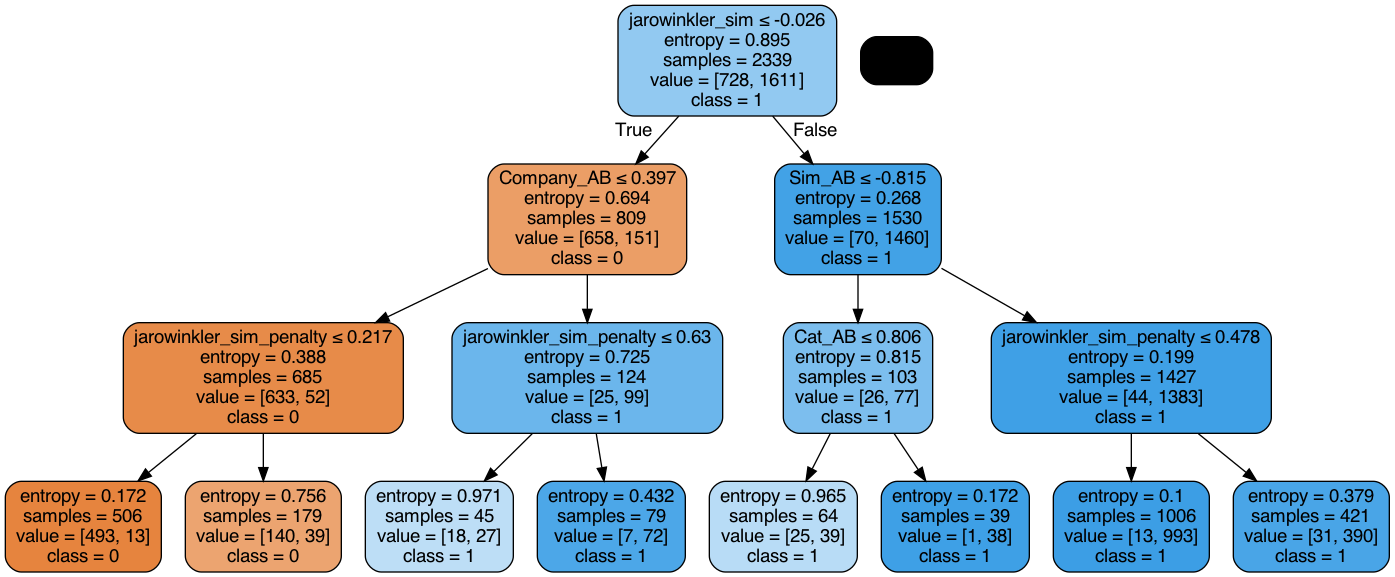

In [383]:
feature_cols = ['Company_AB','Desc_AB','jarowinkler_sim','jarowinkler_sim_penalty','Cat_AB','Sim_AB']
from sklearn.tree import export_graphviz
from six import StringIO 
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# graph.write_png('DTree_optimized.png')
Image(graph.create_png())

In [384]:
# Check Missclassified Data - Random Forest 
df_3 = pd.DataFrame()
df_3['Actual'] = y_test
df_3['Label_DT'] = y_pred
df_3['Label_KNN'] = y_predict
df_3['Label_SGD'] = predicted_SGD
df_2 = pd.DataFrame(X_test,columns = ['Company_A','Company_B','CompanyA','CompanyB','Company_AB','Desc_AB','jarowinkler_sim','jarowinkler_sim_penalty','Cat_AB','Sim_AB'])
df_2 = df_2.join(df_3)

In [385]:
df_2.to_csv("Output/Test_result_2.csv")

In [184]:
df_2[df_2['Actual']!=df_2['Predicted']][df_2['Predicted'] == 0]

/var/folders/1g/0793y9p52tb41mxnw7d59ndm0000gn/T/ipykernel_22642/723009144.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_2[df_2['Actual']!=df_2['Predicted']][df_2['Predicted'] == 0]


Company_A                  Company_B  \
0          PEPPERL & FUCHS INC                        P&F   
8                       CARTER              CARTER DAY CO   
18                       CROWN                  CROWN ENG   
30                  MARQUIPWAR               WARD MACHINE   
41                     HOFFMAN                     MCLEAN   
46                    APPLETON                       RACO   
50                          CM                        C&M   
69   LIQUID SOLIDS CONTROL INC                        LSC   
73                     GENERAL    GENERAL SAW CORPORATION   
81                      SIEMEN  SIEMENS ENERGY AND AUTOMA   
87                 EXXON MOBIL                      MOBIL   
92                     WESTERN              WESTERN DIAZO   
105             EATON AIR FLEX                     FAWICK   
114                   WURZBURG          WURZBURG BROTHERS   
115         SCHNEIDER ELECTRIC           SQUARE D COMPANY   
117              BOSCH REXROTH                    REXROTH   
129                     YAMAHA            YAMAHA ROBOTICS   
141                EATONVICKER                    VICKERS   
143                        MAC             MAC VALVES INC   
153                     AMETEK                        NCC   
156                    CELLECO                       GL&V   
160            EWELLIX USA LLC                SKF USA INC   
163                        RBC  ROLLER BEARINGS OF AMERIC   
177                MTS SYSTEMS                      TEMPO   
187                        ASC                       ASCO   
199                     BUCHER   BUCHER HYDRAULICS CANADA   
213                 BECK HAROL     HAROLD BECK & SONS INC   
234                MACVALVEINC             MAC VALVES INC   
251                     SAMUEL   SAMUEL PACKAGING SYSTEMS   

                  CompanyA           CompanyB jarowinkler_sim  \
0            pepperl fuchs                p&f             0.0   
8                   carter         carter day        0.707107   
18                   crown          crown eng        0.768413   
30              marquipwar               ward             0.0   
41                 hoffman             mclean             0.0   
46                appleton               raco             0.0   
50                      cm                c&m             0.0   
69   liquid solids control                lsc             0.0   
73                 general        general saw        0.508523   
81                  siemen      energy automa             0.0   
87             exxon mobil              mobil        0.707107   
92                 western      western diazo         0.68718   
105         eaton air flex             fawick             0.0   
114               wurzburg  wurzburg brothers        0.707107   
115              schneider             square             0.0   
117          bosch rexroth            rexroth        0.687383   
129                 yamaha    yamaha robotics        0.707107   
141            eatonvicker            vickers             0.0   
143                    mac         mac valves        0.725163   
153                 ametek                ncc             0.0   
156                celleco               gl&v             0.0   
160                ewellix                skf             0.0   
163                    rbc      roller americ             0.0   
177                    mts              tempo             0.0   
187                    asc               asco             0.0   
199                 bucher      bucher canada         0.75156   
213             beck harol   harold beck sons        0.372979   
234            macvalveinc         mac valves             0.0   
251                 samuel   samuel packaging        0.802771   

    jarowinkler_sim_penalty Company_AB   Desc_AB    Sim_AB    Cat_AB  Actual  \
0                  0.586846       0.52      0.52  0.997991  0.438582     1.0   
8                  0.138939       0.92      0.92  0.045835  0.781813     1.0   

In [189]:
# df_2.to_csv("Output/Prediction_2nd_iter.csv")

## 2nd Approach

In [201]:
# Assign values to the X and y variables:
X = new_data.iloc[:, :10].values
y = new_data.iloc[:, 10].values 

In [202]:
y = y.astype(np.float)

/var/folders/1g/0793y9p52tb41mxnw7d59ndm0000gn/T/ipykernel_22642/3104899586.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = y.astype(np.float)


In [203]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=135)
X_train_new = [x[4:] for x in X_train]
X_test_new = [x[4:] for x in X_test]

In [204]:
from sklearn.impute import SimpleImputer

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp = imp.fit(X_train_new)
X_train_new = imp.transform(X_train_new)
X_test_new = imp.transform(X_test_new) 

# Standardize features by removing mean and scaling to unit variance:
scaler = StandardScaler()
scaler.fit(X_train_new)
X_train_new = scaler.transform(X_train_new)
X_test_new = scaler.transform(X_test_new) 

In [205]:
# Use the KNN classifier to fit data:
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train_new, y_train) 
# Predict y data with classifier: 
y_predict = classifier.predict(X_test_new)
# Print results: 
print(confusion_matrix(y_test, y_predict))
print(classification_report(y_test, y_predict)) 
print(accuracy_score(y_test, y_predict))
cohen_kappa_score(y_test, y_predict)

[[678  23]
 [ 12 547]]
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.97       701
         1.0       0.96      0.98      0.97       559

    accuracy                           0.97      1260
   macro avg       0.97      0.97      0.97      1260
weighted avg       0.97      0.97      0.97      1260

0.9722222222222222


0.9438416870415648

In [206]:
# Random Forest Classifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
threshold = 0.8
trainedforest = RandomForestClassifier(n_estimators=700).fit(X_train_new,y_train)
predicted_proba = trainedforest.predict_proba(X_test_new)
predictionforest = (predicted_proba[:,1] >= threshold).astype('int')

# print(confusion_matrix(y_test,predictionforest))
# print(classification_report(y_test,predictionforest))
# # Evaluate label (subsets) accuracy:
print(accuracy_score(y_test, predictionforest))

print("Cohen kappa",cohen_kappa_score(y_test, predictionforest))

0.9674603174603175
Cohen kappa 0.9338316665300435


In [207]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train_new,y_train)
predicted_proba = clf.predict_proba(X_test_new)
predictionLR = (predicted_proba[:,1] >= threshold).astype('int')

# print(confusion_matrix(y_test,predictionforest))
# print(classification_report(y_test,predictionforest))
# # Evaluate label (subsets) accuracy:
print(accuracy_score(y_test, predictionLR))


0.9238095238095239


In [208]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
sgd = make_pipeline(StandardScaler(),
SGDClassifier(max_iter=1000, tol=1e-3))
sgd.fit(X_train_new,y_train)

predicted_SGD = sgd.predict(X_test_new)
log_probab = sgd.decision_function(X_test_new)

# print(confusion_matrix(y_test,predictionforest))
# print(classification_report(y_test,predictionforest))
# # Evaluate label (subsets) accuracy:
print(accuracy_score(y_test, predicted_SGD))

0.9619047619047619


In [209]:
from sklearn.tree import DecisionTreeClassifier
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3)

# Train Decision Tree Classifer
clf = clf.fit(X_train_new,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test_new)
print(accuracy_score(y_test, y_pred))

0.9706349206349206


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


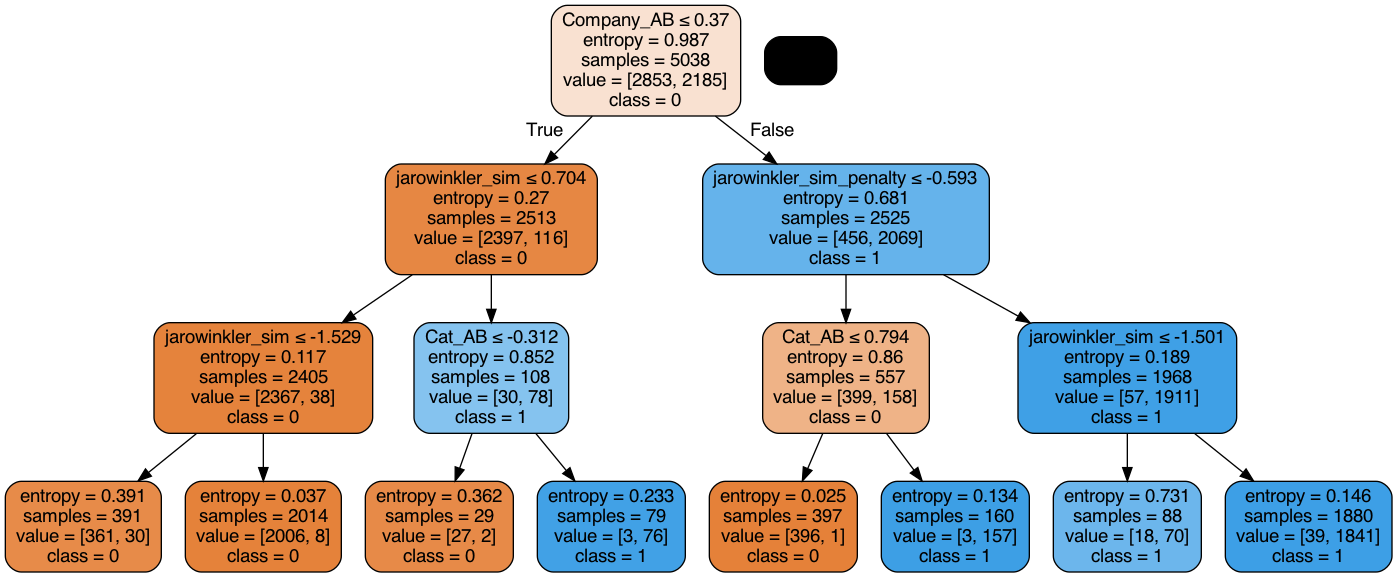

In [210]:
feature_cols = ['Company_AB','Desc_AB','jarowinkler_sim','jarowinkler_sim_penalty','Cat_AB','Sim_AB']
from sklearn.tree import export_graphviz
from six import StringIO 
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
#graph.write_png('DTree_optimized.png')
Image(graph.create_png())

## Testing on Same Test dataset of 1st Iteration

In [214]:
# Assign values to the X and y variables:
X = df.iloc[:, :10].values
y = df.iloc[:, 10].values 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=135)
X_train_new = [x[4:] for x in X_train]
X_test_new = [x[4:] for x in X_test]

In [218]:
X_unseen = imp.transform(X_test_new)
X_unseen = scaler.transform(X_unseen)

In [219]:
# KNN
predictive_labels_KNN = classifier.predict_proba(X_unseen)
threshold = 0.8
predictionKNN = (predictive_labels_KNN[:,1] >= threshold).astype('int')

In [222]:
test_df = pd.DataFrame()
test_df['Label_KNN']  = predictionKNN

In [223]:
predicted_SGD = sgd.predict(X_unseen)
test_df['Label_SGD']  = predicted_SGD

In [224]:
predicted_DT = clf.predict(X_unseen)
test_df['Label_DT']  = predicted_DT

In [226]:
X_test

array([['PEPPERL & FUCHS INC', 'P&F', 'pepperl fuchs', ..., 0.52,
        0.9979911987655324, 0.4385819733142853],
       ['ENVIRONMENTAL ELEMENTS CO', 'FORRY INC',
        'environmental elements', ..., 0.42, 0.8947510273798946,
        0.06310588121414185],
       ['ALLEN BRADLEY', 'CARMANAH DES', 'allen bradley', ..., 0.61,
        0.2512348129102518, 0.20917551219463348],
       ...,
       ['SIEMENS APPLIED AUTOMATIO', 'SIEMENS ENERGY AND AUTOMA',
        'applied automatio', ..., 0.7, 0.9704033911923404,
        0.742530345916748],
       ['ALLEN BRADLEY', 'FSC', 'allen bradley', ..., 0.0,
        0.9843128785116342, 0.14555947482585907],
       ['M&CPRODUCT', 'M&CPRODUCTS', 'm&cproduct', ..., 0.98,
        0.8698809765627862, 0.9514281749725342]], dtype=object)

In [227]:
# Check Missclassified Data - Random Forest 
df_3 = pd.DataFrame()
df_3['Actual'] = y_test
df_3['Predicted'] = predicted_DT
df_2 = pd.DataFrame(X_test,columns = ['Company_A','Company_B','CompanyA','CompanyB','jarowinkler_sim','jarowinkler_sim_penalty','Company_AB','Desc_AB','Sim_AB','Cat_AB'])
df_2 = df_2.join(df_3)

In [228]:
df_2

Company_A                  Company_B  \
0          PEPPERL & FUCHS INC                        P&F   
1    ENVIRONMENTAL ELEMENTS CO                  FORRY INC   
2                ALLEN BRADLEY               CARMANAH DES   
3                    FLOWSERVE                   STERLING   
4    GOULDS PUMPS / ITT INDUST                    REXROTH   
..                         ...                        ...   
260              HARNISCHFEGER   MORRIS MATERIAL HANDLING   
261                METSO PAPER                METSO POWER   
262  SIEMENS APPLIED AUTOMATIO  SIEMENS ENERGY AND AUTOMA   
263              ALLEN BRADLEY                        FSC   
264                 M&CPRODUCT                M&CPRODUCTS   

                   CompanyA                  CompanyB jarowinkler_sim  \
0             pepperl fuchs                       p&f             0.0   
1    environmental elements                     forry             0.0   
2             allen bradley              carmanah des             0.0   
3                 flowserve                  sterling             0.0   
4                                             rexroth             0.0   
..                      ...                       ...             ...   
260           harnischfeger  morris material handling             0.0   
261             metso paper                     metso        0.726563   
262       applied automatio             energy automa             0.0   
263           allen bradley                       fsc             0.0   
264              m&cproduct               m&cproducts             0.0   

    jarowinkler_sim_penalty Company_AB Desc_AB    Sim_AB    Cat_AB  Actual  \
0                  0.586846       0.52    0.52  0.997991  0.438582     1.0   
1                  0.041292       0.42    0.42  0.894751  0.063106     0.0   
2                  0.235243       0.61    0.61  0.251235  0.209176     0.0   
3                  0.093504       0.48    0.48  0.850227  0.354551     0.0   
4                  0.166782        0.0     0.0  0.232534  0.321177     0.0   
..                      ...        ...     ...       ...       ...     ...   
260                0.545393       0.53    0.53  0.979067  0.217532     0.0   
261                 0.08961       0.89    0.89  0.956665  0.779925     0.0   
262                0.274019        0.7     0.7  0.970403   0.74253     1.0   
263                0.109719        0.0     0.0  0.984313  0.145559     0.0   
264                0.234701       0.98    0.98  0.869881  0.951428     1.0   

     Predicted  
0          0.0  
1          0.0  
2          0.0  
3          0.0  
4          0.0  
..         ...  
260        0.0  
261        1.0  
262        1.0  
263        0.0  
264        1.0  

[265 rows x 12 columns]

In [229]:
df_2[df_2['Actual']!=df_2['Predicted']][df_2['Predicted'] == 1]

/var/folders/1g/0793y9p52tb41mxnw7d59ndm0000gn/T/ipykernel_22642/2033149000.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_2[df_2['Actual']!=df_2['Predicted']][df_2['Predicted'] == 1]


Company_A                  Company_B  \
14                        MISC US BEARING                         US   
15                  ERNST FLOW INDUSTRIES                 ERNST GAGE   
17                          CAN-AM CHAINS                   CAN-AMER   
21               METSO AUTOMATION USA INC                METSO PAPER   
52                         PAPE MACHINERY       PAPER MACHINERY CORP   
53               TOSHIBA AMERICA CONSUMER           TOSHIBA ELECTRIC   
58                       PARKER HYDRAULIC          PARKER PNEUMATICS   
59                            CATERPILLAR              CUTLER HAMMER   
79                      QUINCY COMPRESSOR     QUINCY SPECIALITES CO.   
83               METSO AUTOMATION USA INC              METSO/KAJAANI   
104                          PARKER FLUID            PARKER HANNIFIN   
118                    FEDERAL MOGUL CORP                 FEDERALSIG   
131                     QUINCY COMPRESSOR     QUINCY SPECIALITES CO.   
138                         KB ELECTRONIC                       KBIC   
146                   VICTOR EQUIPMENT CO             VICTOR WELDING   
164                   TSUBAKI CONVEYOR CO       TSUBAKIMOTO CHAIN CO   
181             PNEUMATIC & HYDRAULICS CO          PNEUMATIC COMPANY   
182                    MILLER FLUID POWER               MILLER SALES   
202                         REX CHAINBELT            REX ENGINEERING   
207  LINDEN FABRICATING & ENGINEERING LTD       LINDEN MANUFACTURING   
210                  SIGNET SCIENTIFIC CO  SIGNODE PACKAGING SYSTEMS   
217                  MILLER HONEY COMPANY    MILLER SAFETY EQUIPMENT   
220                BROWN PAPER CONVERTING   PAPER CONVERTING MACHINE   
221                                   SUN        SUN HYDRAULICS CORP   
223              ENVIRONMENTAL CONSULTING  ENVIRONMENTAL ELEMENTS CO   
228             TOSHIBA INTERNATIONAL COR               TOSHIBAMERIC   
229                 AES ENGINEERED SYSTEM       ALBANY ENGINEERED SY   
235                               MARQUIP     MARTIN SPROCKET & GEAR   
240                   LITTLE GIANT LADDER          LITTLE GIANT PUMP   
243                               MARQUIP                 MARQUIPWAR   
256               ADAMS MAGNETIC PRODUCTS           MASTER MAGNETICS   
257               LINCOLN LUBE INDUSTRIAL           LINCOLN ST LOUIS   
261                           METSO PAPER                METSO POWER   

                           CompanyA                CompanyB jarowinkler_sim  \
14                               us                      us             1.0   
15                       ernst flow              ernst gage        0.480974   
17                    can-am chains                can-amer        0.393119   
21                            metso             metso paper        0.726563   
52                             pape                   paper             0.0   
53         toshiba america consumer                 toshiba        0.518523   
58                 parker hydraulic       parker pneumatics        0.366785   
59                      caterpillar           cutler hammer             0.0   
79                quincy compressor     quincy specialites         0.489538   
83                            metso           metso kajaani        0.627187   
104                          parker         parker hannifin        0.676678   
118                   federal mogul              federalsig             0.0   
131               quincy compressor     quincy specialites         0.489538   
138                              kb                    kbic             0.0   
146                          victor          victor welding         0.68006   
164                tsubaki conveyor       tsubakimoto chain             0.0   
181                       pneumatic               pneumatic             1.0   
182                          miller                  miller             1.0   
202                   rex chainbelt         rex engineering        0.487742   
207

In [231]:
len(df_2[df_2['Actual']!=df_2['Predicted']][df_2['Predicted'] == 0])

/var/folders/1g/0793y9p52tb41mxnw7d59ndm0000gn/T/ipykernel_22642/2204474174.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(df_2[df_2['Actual']!=df_2['Predicted']][df_2['Predicted'] == 0])


29

In [232]:
len(df_2[df_2['Actual']!=df_2['Predicted']][df_2['Predicted'] == 1])

/var/folders/1g/0793y9p52tb41mxnw7d59ndm0000gn/T/ipykernel_22642/4128229866.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(df_2[df_2['Actual']!=df_2['Predicted']][df_2['Predicted'] == 1])


33

In [234]:
df_2[df_2['Actual']!=df_2['Predicted']][df_2['Predicted'] == 0]


/var/folders/1g/0793y9p52tb41mxnw7d59ndm0000gn/T/ipykernel_22642/3950092250.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_2[df_2['Actual']!=df_2['Predicted']][df_2['Predicted'] == 0]


Company_A                  Company_B  \
0          PEPPERL & FUCHS INC                        P&F   
8                       CARTER              CARTER DAY CO   
18                       CROWN                  CROWN ENG   
30                  MARQUIPWAR               WARD MACHINE   
41                     HOFFMAN                     MCLEAN   
46                    APPLETON                       RACO   
50                          CM                        C&M   
69   LIQUID SOLIDS CONTROL INC                        LSC   
73                     GENERAL    GENERAL SAW CORPORATION   
81                      SIEMEN  SIEMENS ENERGY AND AUTOMA   
87                 EXXON MOBIL                      MOBIL   
92                     WESTERN              WESTERN DIAZO   
105             EATON AIR FLEX                     FAWICK   
114                   WURZBURG          WURZBURG BROTHERS   
115         SCHNEIDER ELECTRIC           SQUARE D COMPANY   
117              BOSCH REXROTH                    REXROTH   
129                     YAMAHA            YAMAHA ROBOTICS   
141                EATONVICKER                    VICKERS   
143                        MAC             MAC VALVES INC   
153                     AMETEK                        NCC   
156                    CELLECO                       GL&V   
160            EWELLIX USA LLC                SKF USA INC   
163                        RBC  ROLLER BEARINGS OF AMERIC   
177                MTS SYSTEMS                      TEMPO   
187                        ASC                       ASCO   
199                     BUCHER   BUCHER HYDRAULICS CANADA   
213                 BECK HAROL     HAROLD BECK & SONS INC   
234                MACVALVEINC             MAC VALVES INC   
251                     SAMUEL   SAMUEL PACKAGING SYSTEMS   

                  CompanyA           CompanyB jarowinkler_sim  \
0            pepperl fuchs                p&f             0.0   
8                   carter         carter day        0.707107   
18                   crown          crown eng        0.768413   
30              marquipwar               ward             0.0   
41                 hoffman             mclean             0.0   
46                appleton               raco             0.0   
50                      cm                c&m             0.0   
69   liquid solids control                lsc             0.0   
73                 general        general saw        0.508523   
81                  siemen      energy automa             0.0   
87             exxon mobil              mobil        0.707107   
92                 western      western diazo         0.68718   
105         eaton air flex             fawick             0.0   
114               wurzburg  wurzburg brothers        0.707107   
115              schneider             square             0.0   
117          bosch rexroth            rexroth        0.687383   
129                 yamaha    yamaha robotics        0.707107   
141            eatonvicker            vickers             0.0   
143                    mac         mac valves        0.725163   
153                 ametek                ncc             0.0   
156                celleco               gl&v             0.0   
160                ewellix                skf             0.0   
163                    rbc      roller americ             0.0   
177                    mts              tempo             0.0   
187                    asc               asco             0.0   
199                 bucher      bucher canada         0.75156   
213             beck harol   harold beck sons        0.372979   
234            macvalveinc         mac valves             0.0   
251                 samuel   samuel packaging        0.802771   

    jarowinkler_sim_penalty Company_AB   Desc_AB    Sim_AB    Cat_AB  Actual  \
0                  0.586846       0.52      0.52  0.997991  0.438582     1.0   
8                  0.138939       0.92      0.92  0.045835  0.781813     1.0   